In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from scipy.optimize import root
from scipy.integrate import quad

# Fancy plots using latex and nice fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12
})

In [59]:
def solve_poly(z, sigma, kappa):
    alpha = 1 / kappa
    R_noise = sigma**2
    a3 = np.sqrt(alpha) * R_noise
    a2 = -(np.sqrt(alpha) * z + R_noise)
    a1 = (z + np.sqrt(alpha) - alpha**(-1 / 2))
    a0 = -1

    coefficients = [a3, a2, a1, a0]

    return np.roots(coefficients)

def edges_rho(sigma, kappa):
    alpha = 1/kappa
    R_noise = sigma**2

    a0 = -12 * R_noise + (4 * R_noise) / alpha + 12 * alpha * R_noise - 4 * alpha**2 * R_noise - 20 * R_noise**2 + R_noise**2 / alpha - 8 * alpha * R_noise**2 - 4 * R_noise**3
    a1 = -(10 * R_noise) / np.sqrt(alpha) + 2 * np.sqrt(alpha) * R_noise + 8 * alpha**(3/2) * R_noise - (2 * R_noise**2) / np.sqrt(alpha) + 8 * np.sqrt(alpha) * R_noise**2
    a2 = 1 - 2 * alpha + alpha**2 + 8 * R_noise - 2 * alpha * R_noise + R_noise**2
    a3 = -2 * np.sqrt(alpha) - 2 * alpha**(3/2) - 2 * np.sqrt(alpha) * R_noise
    a4 = alpha

    coefficients = [a4, a3, a2, a1, a0]

    roots_all = np.roots(coefficients)
    real_roots = np.real(roots_all[np.abs(np.imag(roots_all)) < 1e-10])

    return np.sort(real_roots)

def rho(x, sigma, kappa):        
    return np.max(np.imag(solve_poly(x-1e-12j, sigma, kappa))) / np.pi

def mass_upper_bulk(delta,kappa):
    edges = edges_rho(delta, kappa)
    if len(edges)==2:
        return np.nan
    else:
        return quad(lambda x: rho(x,delta,kappa),edges[2],edges[3])[0]

def rank(delta, epsilon, kappa):
    edges = edges_rho(delta, kappa)
    cdf = 0
    if len(edges)==2:
        if epsilon <= edges[0]:
            cdf = 0
        elif edges[0] < epsilon < edges[1]:
            cdf = quad(lambda x: rho(x,delta,kappa),edges[0],epsilon)[0]
        else:
            cdf = 1
    else:
        if epsilon < edges[0]:
            cdf = 0
        elif edges[0] < epsilon < edges[1]:
            cdf = quad(lambda x: rho(x,delta,kappa),edges[0],epsilon)[0]
        elif edges[1] <= epsilon <= edges[2]:
            cdf = quad(lambda x: rho(x,delta,kappa),edges[0],edges[1])[0]
        elif edges[2] < epsilon < edges[3]:
            cdf = quad(lambda x: rho(x,delta,kappa),edges[0],edges[1])[0] + quad(lambda x: rho(x,delta,kappa),edges[2],epsilon)[0]
        else:
            cdf = 1
    return 1-cdf

def plot_spectrum_theory(alpha, lreg=0.01, kappa=0.5, noise=0.5):
    df = pd.read_csv("data/spectra/theory_spectra.csv")


    row = df[df['alpha'] == alpha].iloc[0]

    q_hat = row['q_hat']
    m_hat = row['m_hat']
    delta = np.sqrt(q_hat)/m_hat
    epsilon = lreg * 2 / m_hat

    # Teacher spectrum
    def rho_plot(x):
        return 2*x*rho(x**2, 0, kappa)
    edges_val = edges_rho(0.0, kappa)

    if len(edges_val) == 2:
        x_base_teacher = np.linspace(np.sqrt(edges_val[0]), np.sqrt(edges_val[1]), 500)
    elif len(edges_val) == 4:
        x_base1 = np.linspace(np.sqrt(edges_val[0]), np.sqrt(edges_val[1]), 250)
        x_base2 = np.linspace(np.sqrt(edges_val[2]), np.sqrt(edges_val[3]), 250)
        x_base_teacher = np.concatenate((x_base1, x_base2))

    y_base_teacher = np.array([rho_plot(x) for x in x_base_teacher])

    # Student spectrum
    def rho_plot_student(x):
        return 2*x*rho(x**2+epsilon, delta, kappa)
    edges_val = edges_rho(delta, kappa)
    if edges_val[0] < 0:
        edges_val[0] = 0.0

    x_base_student = np.linspace(0.0, 2.2, 500)
    y_base_student = np.array([rho_plot_student(x) for x in x_base_student])


    return x_base_student, y_base_student, x_base_teacher, y_base_teacher

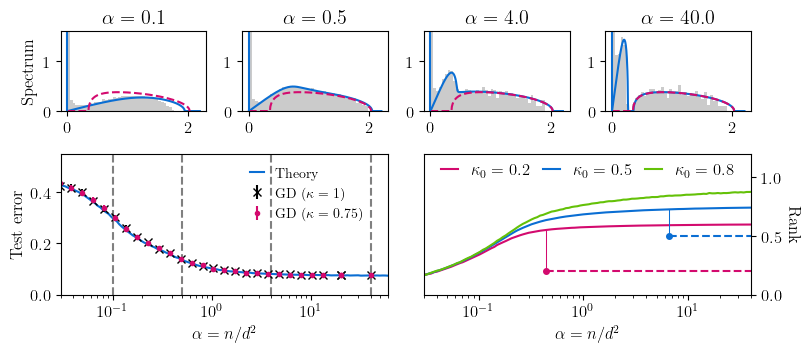

In [60]:
fig_width = 8.27  # inches
fig_height = 3.69  # inches

fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(5, 4, figure=fig)  # 2 rows, 6 columns

# Top row: 3 plots
ax0 = fig.add_subplot(gs[0:2, 0])
ax1 = fig.add_subplot(gs[0:2, 1])
ax2 = fig.add_subplot(gs[0:2, 2])
ax3 = fig.add_subplot(gs[0:2, 3])

# Bottom row: 1 plot spanning all 3 columns
ax4 = fig.add_subplot(gs[2:, :2])
ax5 = fig.add_subplot(gs[2:, 2:])

# colors
myred = "#d30a6e"
mybluelight = "#989898"
myblue = "#0a6ed3"

lreg = 0.01
kappa = 0.5
noise = 0.5

bins = 40
x_max_hist = 1.6

alpha = 0.1

x_base_student, y_base_student, x_base_teacher, y_base_teacher = plot_spectrum_theory(alpha, lreg=lreg, kappa=kappa, noise=noise)

ax0.plot(x_base_student, y_base_student, label='Student spectrum (theory)', color=myblue)
ax0.plot(x_base_teacher, y_base_teacher, label='Teacher spectrum (theory)', color=myred, linestyle='--')

df = pd.read_csv(f"data/spectra/spectrum_alpha_{alpha}_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
ax0.hist(df['eigenvalue'], bins=bins, density=True, alpha=0.5, label='Student spectrum (empirical)', color=mybluelight)
ax0.set_title(rf'$\alpha = {alpha}$')
ax0.set_ylim(0, x_max_hist)
ax0.axvline(x=0.0, color=myblue, linestyle='-')

ax0.set_ylabel("Spectrum")


alpha = 0.5

x_base_student, y_base_student, x_base_teacher, y_base_teacher = plot_spectrum_theory(alpha, lreg=lreg, kappa=kappa, noise=noise)

ax1.plot(x_base_student, y_base_student, label='Student spectrum (theory)', color=myblue)
ax1.plot(x_base_teacher, y_base_teacher, label='Teacher spectrum (theory)', color=myred, linestyle='--')

df = pd.read_csv(f"data/spectra/spectrum_alpha_{alpha}_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
ax1.hist(df['eigenvalue'], bins=bins, density=True, alpha=0.5, label='Student spectrum (empirical)', color=mybluelight)
ax1.set_title(rf'$\alpha = {alpha}$')
ax1.set_ylim(0, x_max_hist)
ax1.axvline(x=0.0, color=myblue, linestyle='-')


alpha = 4.0

x_base_student, y_base_student, x_base_teacher, y_base_teacher = plot_spectrum_theory(alpha, lreg=lreg, kappa=kappa, noise=noise)

ax2.plot(x_base_student, y_base_student, label='Student spectrum (theory)', color=myblue)
ax2.plot(x_base_teacher, y_base_teacher, label='Teacher spectrum (theory)', color=myred, linestyle='--')

df = pd.read_csv(f"data/spectra/spectrum_alpha_{alpha}_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
ax2.hist(df['eigenvalue'], bins=bins, density=True, alpha=0.5, label='Student spectrum (empirical)', color=mybluelight)
ax2.set_title(rf'$\alpha = {alpha}$')
ax2.set_ylim(0, x_max_hist)
ax2.axvline(x=0.0, color=myblue, linestyle='-')


alpha = 40.0

x_base_student, y_base_student, x_base_teacher, y_base_teacher = plot_spectrum_theory(alpha, lreg=lreg, kappa=kappa, noise=noise)

ax3.plot(x_base_student, y_base_student, label='Student spectrum (theory)', color=myblue)
ax3.plot(x_base_teacher, y_base_teacher, label='Teacher spectrum (theory)', color=myred, linestyle='--')

df = pd.read_csv(f"data/spectra/spectrum_alpha_{alpha}_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
ax3.hist(df['eigenvalue'], bins=bins, density=True, alpha=0.5, label='Student spectrum (empirical)', color=mybluelight)
ax3.set_title(rf'$\alpha = {alpha}$')
ax3.set_ylim(0, x_max_hist)
ax3.axvline(x=0.0, color=myblue, linestyle='-')

df = pd.read_csv(f"data/spectra/SE_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
ax4.plot(df['alpha'], df['test'], color=myblue, marker='', linestyle='-', label="Theory")

df = pd.read_csv(f"data/spectra/GD_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
alpha_list = df['alpha'].values
test_error_mean = df['test_error_mean'].values
test_error_std = df['test_error_std'].values
alpha_list = np.concatenate([alpha_list[::2], alpha_list[-2:]])
test_error_mean = np.concatenate([test_error_mean[::2], test_error_mean[-2:]])
test_error_std = np.concatenate([test_error_std[::2], test_error_std[-2:]])
ax4.errorbar(alpha_list, test_error_mean, yerr=test_error_std, color="black", marker='x', linestyle='', label=r"GD ($\kappa = 1$)")#, markeredgecolor='black')


colors = ["#d30a6e", "#0a6ed3", "#64c108"]

df = pd.read_csv(f"data/spectra/GD_kappa_student_{0.75}_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
alpha_list = df['alpha'].values
test_error_mean = df['test_error_mean'].values
test_error_std = df['test_error_std'].values
alpha_list = np.concatenate([alpha_list[::2], alpha_list[-2:]])
test_error_mean = np.concatenate([test_error_mean[::2], test_error_mean[-2:]])
test_error_std = np.concatenate([test_error_std[::2], test_error_std[-2:]])
ax4.errorbar(alpha_list, test_error_mean, yerr=test_error_std, color=colors[0], marker='.', linestyle='', label=r"GD ($\kappa = 0.75$)")#, markeredgecolor='black')



ax4.axvline(x=0.1, color='grey', linestyle='--')
ax4.axvline(x=0.5, color='grey', linestyle='--')
ax4.axvline(x=4.0, color='grey', linestyle='--')
ax4.axvline(x=40.0, color='grey', linestyle='--')

ax4.set_xlim(0.03, 60)
ax4.set_xscale('log')

ax4.set_xlabel(r'$\alpha = n / d^2$')
ax4.set_ylabel('Test error')
ax4.set_ylim(0,0.55)


ax4.legend(framealpha=1, frameon=False, handlelength=1, loc = "upper left", bbox_to_anchor=(0.54,0.99), fontsize=10)

colors = ["#d30a6e", "#0a6ed3", "#64c108"]

height_line = [2.7, 1.45, 1.]
for i, kappa in enumerate([0.2, 0.5, 0.8]):
    df = pd.read_csv(f"data/spectra/rank_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    ax5.plot(df['alpha'], df['rank'], marker='', linestyle='-', label=rf'$\kappa_0 = {kappa}$', color = colors[i])

    df = pd.read_csv(f"data/spectra/SE_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    df.sort_values(by="alpha")
    delta = np.sqrt(df.q_hat.to_numpy()) / df.m_hat.to_numpy()
    mass_ub = [mass_upper_bulk(d, kappa) for d in delta]
    
    ax5.plot(df['alpha'], mass_ub , marker='', linestyle='--', color = colors[i])
    valid = np.where(~np.isnan(mass_ub))[0]
    idx = valid[0] if valid.size > 0 else 0
    ax5.plot([df['alpha'][idx]], [mass_ub[idx]], marker='o', linestyle='', color = colors[i], markersize=4)
    ax5.plot([df['alpha'][idx], df['alpha'][idx]], [mass_ub[idx], mass_ub[idx]*height_line[i]], marker='', linestyle='-', color = colors[i], linewidth=0.75)
    
    # ax5.plot([10,1e4], [kappa,kappa], marker='', linestyle='--', color = colors[i])

ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.set_ylabel('Rank', rotation=270, labelpad=14)
ax5.set_xlabel(r'$\alpha = n / d^2$')

ax5.set_xscale('log')
ax5.set_xlim(0.03, 40)
ax5.set_ylim(0,1.2)
# ax5.set_yticks(0,1.2)

ax5.legend(framealpha=1, loc="lower center", handlelength=1, ncol=3, columnspacing=0.8, bbox_to_anchor=(0.5, 0.72), frameon=False)

plt.tight_layout()
plt.savefig('figures/Figure1.pdf', format='pdf', bbox_inches='tight')
plt.show()

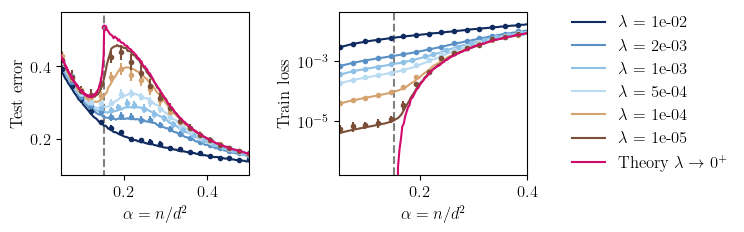

In [4]:
fig_width = 8.27  # inches
fig_height = 3.69/3*2  # inches

kappa = 0.5
noise = 0.5

start=0
sparse=3

fig = plt.figure(figsize=(fig_width, fig_height))

plt.subplot(1,2,1)

colors = ["#0F2B5FFF", "#5991C7FF", "#8EC1E7FF", "#B9DBF1FF", "#D5A370FF", "#7B4F37FF"]
myred = "#d30a6e"

plt.vlines(x=0.3069641786653554/2, ymin=0, ymax=10, color="grey", linestyle="--")

for i,lreg in enumerate([0.01, 0.002, 0.001, 0.0005, 0.0001, 0.00001]):
    df = pd.read_csv(f"data/GD/GD_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    plt.errorbar(df['alpha'][start::sparse], df['test_error_mean'][start::sparse], yerr=df['test_err_std'][start::sparse], marker='.', linestyle='', label=rf'$\lambda = {lreg}$', color = colors[i])

    df = pd.read_csv(f"data/SE/SE_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    plt.plot(df['alpha'], df['test'], color = colors[i])

df = pd.read_csv(f"data/SE/SE_kappa_{kappa}_lreg_{0.0}_noise_{noise}.csv")
plt.plot(df['alpha'], df['test'], color=myred, label='Theory', linestyle='-', zorder=100)

plt.xlim(0.05, 0.5)
plt.ylim(0.1, 0.55)
plt.ylabel("Test error")
plt.xlabel(r'$\alpha = n / d^2$')



# TODO: input analytical value
plt.scatter(x=[0.3069641786653554/2], y=[0.5088960290319867], color=myred, label="Theory", s=10)

plt.subplot(1,2,2)

plt.axvline(x=0.3069641786653554/2, color="grey", linestyle="--")

for i,lreg in enumerate([0.01, 0.002, 0.001, 0.0005, 0.0001, 0.00001]):
    df = pd.read_csv(f"data/GD/GD_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    plt.errorbar(df['alpha'][start::sparse], df['loss_mean'][start::sparse], yerr=df['loss_std'][start::sparse], marker='.', linestyle='', color = colors[i])

    df = pd.read_csv(f"data/SE/SE_kappa_{kappa}_lreg_{lreg}_noise_{noise}.csv")
    plt.plot(df['alpha'], df['train'], color = colors[i], label=rf'$\lambda$ = {lreg:.0e}')


df = pd.read_csv(f"data/SE/SE_kappa_{kappa}_lreg_{0.0}_noise_{noise}.csv")
plt.plot(df['alpha'], df['train'], color=myred, label=r'Theory $\lambda \to 0^+$', linestyle='-', zorder=100)

plt.legend(loc = "center", bbox_to_anchor=(1.65, 0.5), framealpha=0)

plt.xlim(0.05, 0.4)
plt.ylabel("Train loss")
# plt.ylim(0., 0.015)
plt.yscale('log')
plt.xlabel(r'$\alpha = n / d^2$')

# plt.axvline(x=0.3069641786653554/2, color="black", label="Theory")
plt.tight_layout()
plt.savefig("figures/Figure2.pdf")

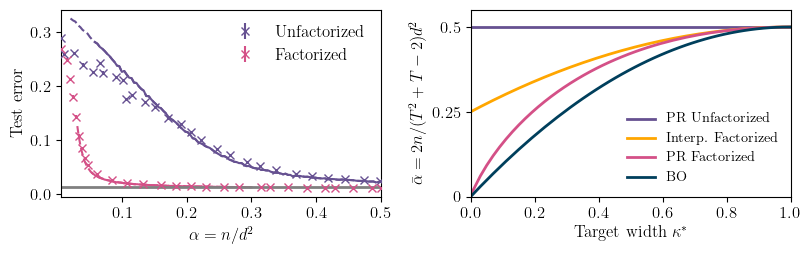

In [ ]:
fig_width = 8.27  # inches
fig_height = 2.7  # inches

kappa = 0.05
noise = 0.05

fig = plt.figure(figsize=(fig_width, fig_height))

    
colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.subplot(1,2,1)


df = pd.read_csv(f'data/cross_validation/SE_L1_kappa_{kappa}_noise_{noise}.csv')
alpha_tilde = df['alpha'].values #/ kappa
test = df['test'].values
plt.plot(alpha_tilde, test, marker='', linestyle='--', color=colors[4], zorder=-100)
plt.plot(alpha_tilde[10:], test[10:], marker='', linestyle='-', color=colors[4], zorder=-100)
plt.axhline(y=test[-1], color='grey', linestyle='-', lw=2)

df = pd.read_csv(f'data/cross_validation/SE_L2_kappa_{kappa}_noise_{noise}.csv')
alpha_tilde = df['alpha'].values# / kappa
test = df['test'].values
plt.plot(alpha_tilde, test, marker='', linestyle='--', color=colors[2], zorder=-100)
plt.plot(alpha_tilde[10:], test[10:], marker='', linestyle='-', color=colors[2], zorder=-100)


df = pd.read_csv(f'data/cross_validation/GD_L2_kappa_{kappa}_noise_{noise}.csv')
plt.errorbar(df['alpha'], df['test_err_mean_opt'], yerr=df['test_err_std_opt']/np.sqrt(8), marker='x', linestyle='',label=r'$\rm Unfactorized$', color=colors[2], zorder = 100)

df = pd.read_csv(f'data/cross_validation/GD_L1_kappa_{kappa}_noise_{noise}.csv')
plt.errorbar(df['alpha'], df['test_err_mean_opt'], yerr=df['test_err_std_opt']/np.sqrt(8), marker='x', linestyle='',label=r'$\rm Factorized$', color=colors[4], zorder = 100)


plt.ylabel("Test error")
plt.xlabel(r'$\alpha= n / d^2$')
plt.xlim(0.005, 0.5)



plt.legend(frameon=False)


plt.subplot(1,2,2)

def BO_strong(kappa):
    if kappa >= 1:
        return 0.5
    else:
        return kappa - kappa**2 /2
    

######## ALPHA STRONG ERM
def ERM_integralP(x, k):
    def f(t):
        if -2 < t < 2:
            return np.sqrt(4 - t**2) * t**k
        else:
            return 0
    return 1/(2 * np.pi) * quad(lambda t: f(t), -2, x)[0]
def ERM_eq(kappa, lambdabar):
    def F(c):
        return c - lambdabar / (2 * c * (1-kappa))  - (1-kappa) * ( c * ERM_integralP(c, 0) - ERM_integralP(c, 1))
    return root(F, 1).x[0]
def ERM_strong(kappa, lambdabar):
    if kappa >= 1:
        return 0.5
    else:
        c = ERM_eq(kappa, lambdabar)
        return 1/2 + lambdabar / (4 * c) - 1/2 * (1-kappa)**2 * ( ERM_integralP(c, 2) - c * ERM_integralP(c, 1))
    
colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

DDs = [0, 0.01, 0.1, 0.5, 1]
kappas = np.linspace(-2, 2, 200)
res = np.genfromtxt("data/cross_validation/interpolation.csv", delimiter=",")
bo = [ BO_strong(k) for k in kappas]
mnne =  [ ERM_strong(k,0) for k in kappas]
interp =  [ (1+2*k-k**2)/4 if k <1 else 1/2 for k in kappas]


plt.plot(kappas, 0.5 * np.ones_like(kappas), label = "PR Unfactorized", color = colors[2], lw=2)
plt.plot(kappas, interp, label = "Interp. Factorized", color = colors[7], lw=2)
plt.plot(kappas, mnne, label = "PR  Factorized", color = colors[4], lw=2)
plt.plot(kappas, bo, label = "BO", color = colors[0], lw=2)


plt.xlabel(r"Target width $\kappa^*$")

plt.yticks(ticks=[0,0.25,0.5],labels=["0","0.25","0.5"],color="black")

plt.xlim((0,1))
plt.ylim((0., 0.55))
plt.legend(fontsize='small', markerscale=2, frameon=False)


plt.ylabel(r'$\bar{\alpha} = 2n/(T^2+T-2)d^2$')
plt.tight_layout()



plt.savefig("figures/Figure3.pdf")
plt.show()


## Seq2seq

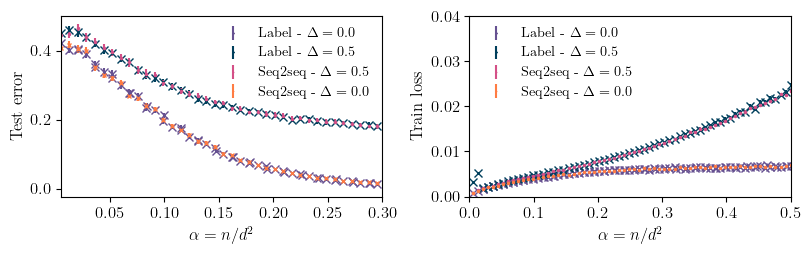

In [57]:
fig_width = 8.27  # inches
fig_height = 2.7  # inches


fig = plt.figure(figsize=(fig_width, fig_height))

    
colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.subplot(1,2,1)

df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.00_D100_label.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='x', linestyle='', color=colors[2], label=r"Label - $\Delta=0.0$")

df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.50_D100_label.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean_noise'], yerr=df['_test_err_std_noise'], marker='x', linestyle='', color=colors[0], label=r"Label - $\Delta=0.5$")


df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.50_D100_seq2seq.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"Seq2seq - $\Delta=0.5$")


df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.00_D100_seq2seq.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='x', linestyle='', color=colors[6],markersize=3, label=r"Seq2seq - $\Delta=0.0$")


plt.ylabel("Test error")
plt.xlabel(r'$\alpha= n / d^2$')
plt.xlim(0.005, 0.3)

plt.legend(fontsize='small', markerscale=0.2, frameon=False)

plt.subplot(1,2,2)

colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]



df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.00_D100_label.csv')
plt.errorbar(df['_alpha'], df['_train_total_loss_mean'], yerr=df['_train_total_loss_std'], marker='x', linestyle='', color=colors[2], label=r"Label - $\Delta=0.0$")

df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.50_D100_label.csv')
plt.errorbar(df['_alpha'], df['_train_total_loss_mean'], yerr=df['_train_total_loss_std'], marker='x', linestyle='', color=colors[0], label=r"Label - $\Delta=0.5$")


df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.50_D100_seq2seq.csv')
plt.errorbar(df['_alpha'], df['_train_total_loss_mean'], yerr=df['_train_total_loss_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"Seq2seq - $\Delta=0.5$")


df = pd.read_csv(f'data/seq2seq/lam_0.01_Delta_in0.00_D100_seq2seq.csv')
plt.errorbar(df['_alpha'], df['_train_total_loss_mean'], yerr=df['_train_total_loss_std'], marker='.', linestyle='', color=colors[6],markersize=3, label=r"Seq2seq - $\Delta=0.0$")


plt.xlabel(r'$\alpha= n / d^2$')

plt.xlim((0,0.5))
plt.ylim((0., 0.04))
plt.legend(fontsize='small', markerscale=0.2, frameon=False)


plt.ylabel(r'Train loss')
plt.tight_layout()


plt.savefig("figures/Figure4.pdf")
plt.show()


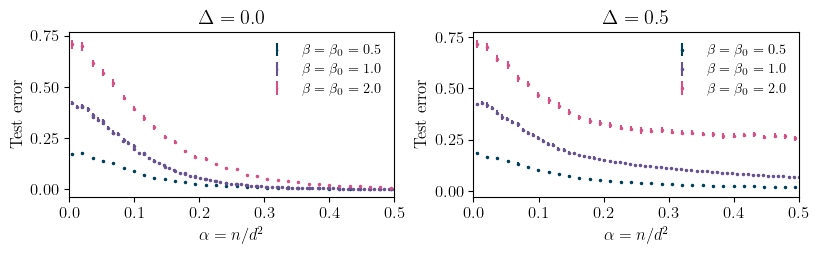

In [69]:
fig_width = 8.27  # inches
fig_height = 2.7  # inches


fig = plt.figure(figsize=(fig_width, fig_height))

    
colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.subplot(1,2,1)
plt.title(rf"$\Delta=0.0$")

df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.00_D100_beta05.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[0],markersize=3, label=r"$\beta=\beta_0=0.5$")

df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.00_D100_beta1.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[2],markersize=3, label=r"$\beta=\beta_0=1.0$")


df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.00_D100_beta2.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"$\beta=\beta_0=2.0$")



plt.ylabel("Test error")
plt.xlabel(r'$\alpha= n / d^2$')
plt.xlim(0, 0.5)

plt.legend(fontsize='small', markerscale=0.2, frameon=False)

plt.subplot(1,2,2)

colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.title(rf"$\Delta=0.5$")

df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.50_D100_beta05.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[0],markersize=3, label=r"$\beta=\beta_0=0.5$")

df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.50_D100_beta1.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[2],markersize=3, label=r"$\beta=\beta_0=1.0$")



df = pd.read_csv(f'data/beta/lam_0.01_Delta_in0.50_D100_beta2.csv')
plt.errorbar(df['_alpha'], df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"$\beta=\beta_0=2.0$")



plt.xlabel(r'$\alpha= n / d^2$')
# ("Thresholds at $\\Delta = 0$")

# plt.yticks(ticks=[0,0.25,0.5],labels=["0","0.25","0.5"],color="black")

plt.xlim((0,0.5))
# plt.ylim((0, 1))
# plt.legend(loc='upper right', frameon=True, handlelength=1, markerscale=0.2)

plt.legend(fontsize='small',frameon = False)

plt.ylabel(r'Test error')
plt.tight_layout()


plt.savefig("figures/Figure5.pdf")
plt.show()


## Tokens NOISELESS

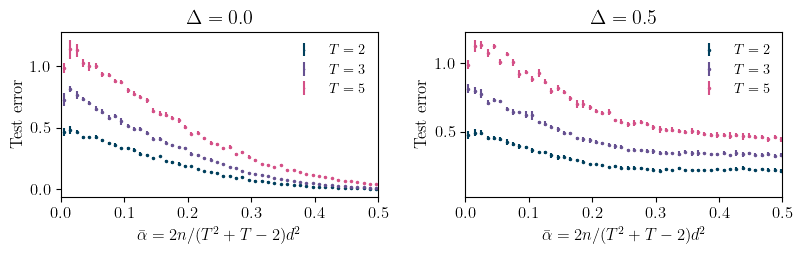

In [77]:
fig_width = 8.27  # inches
fig_height = 2.7  # inches


fig = plt.figure(figsize=(fig_width, fig_height))

    
colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.subplot(1,2,1)
plt.title(rf"$\Delta=0.0$")

df = pd.read_csv(f'data/more_tokens/noiseless/lam_0.01_Delta_in0.00_D100_T2_beta1.0.csv')
plt.errorbar(df['_alpha']*2, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='',markersize=3, color=colors[0], label=r"$T=2$")

df = pd.read_csv(f'data/more_tokens/noiseless/lam_0.01_Delta_in0.00_D100_T3_beta1.0.csv')
plt.errorbar(df['_alpha']*5, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='',markersize=3, color=colors[2], label=r"$T=3$")


df = pd.read_csv(f'data/more_tokens/noiseless/lam_0.01_Delta_in0.00_D100_T5_beta1.0.csv')
plt.errorbar(df['_alpha']*14, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"$T=5$")



plt.ylabel("Test error")
plt.xlabel(r'$\bar{\alpha}= 2n/(T^2 +T -2)d^2$')
plt.xlim(0, 0.5)

plt.legend(fontsize='small', markerscale=0.2, frameon=False)

plt.subplot(1,2,2)

colors = [
    "#003f5c", "#2f4b7c", "#665191", "#a05195", 
    "#d45087", "#f95d6a", "#ff7c43", "#ffa600"
]

plt.title(rf"$\Delta=0.5$")

df = pd.read_csv(f'data/more_tokens/noisy/lam_0.01_Delta_in0.50_D100_T2_beta1.0.csv')
plt.errorbar(df['_alpha']*2, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', markersize=3,color=colors[0], label=r"$T=2$")

df = pd.read_csv(f'data/more_tokens/noisy/lam_0.01_Delta_in0.50_D100_T3_beta1.0.csv')
plt.errorbar(df['_alpha']*5, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', markersize=3,color=colors[2], label=r"$T=3$")



df = pd.read_csv(f'data/more_tokens/noisy/lam_0.01_Delta_in0.50_D100_T5_beta1.0.csv')
plt.errorbar(df['_alpha']*14, df['_test_err_mean'], yerr=df['_test_err_std'], marker='.', linestyle='', color=colors[4], markersize=3, label=r"$T=5$")



plt.xlabel(r'$\bar{\alpha}= 2n/(T^2 +T -2)d^2$')
# ("Thresholds at $\\Delta = 0$")

# plt.yticks(ticks=[0,0.25,0.5],labels=["0","0.25","0.5"],color="black")

plt.xlim((0,0.5))
# plt.ylim((0, 1))
# plt.legend(loc='upper right', frameon=True, handlelength=1, markerscale=0.2)

plt.legend(fontsize='small',frameon = False)

plt.ylabel(r'Test error')
plt.tight_layout()


plt.savefig("figures/Figure6.pdf")
plt.show()
